In [1]:
import os
import random
import shutil
import copy
import time
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np 
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from glob import glob
from skimage.io import imread
from os import listdir

In [2]:
# Ruta de la carpeta principal
main_folder = "/home/xnmaster/dataset"

# ResNet input size
input_size = (224, 224)

In [3]:
# Just normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")


Initializing Datasets and Dataloaders...


In [4]:
# Batch size for training (change depending on how much memory you have)
batch_size = 8 #8

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(main_folder, x), data_transforms[x]) for x in ['train', 'val','test']}

# Generamos los índices para el subconjunto
subset_indices_train = torch.randperm(len(image_datasets['train']))[:int(0.3*len(image_datasets['train']))]
subset_indices_val = torch.randperm(len(image_datasets['val']))[:int(0.3*len(image_datasets['val']))]
subset_indices_test = torch.randperm(len(image_datasets['test']))[:int(0.3*len(image_datasets['test']))]

# Creamos los subconjuntos
train_data_subset = torch.utils.data.Subset(image_datasets['train'], subset_indices_train)
val_data_subset = torch.utils.data.Subset(image_datasets['val'], subset_indices_val)
test_data_subset = torch.utils.data.Subset(image_datasets['test'], subset_indices_test)

# Create training and validation dataloaders
dataloaders_dict = {
    'train': torch.utils.data.DataLoader(train_data_subset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_data_subset, batch_size=batch_size, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(test_data_subset, batch_size=batch_size, shuffle=True, num_workers=4),
}


In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.item())

                    preds = torch.argmax(outputs, dim=1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item() #running_corrects += torch.sum(preds == labels.data).cpu().numpy()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses



In [6]:
def initialize_model(num_classes):
    # Resnet18 
    model = models.mobilenet_v2(pretrained = True)
    
    # Modify the classifier to output a single value (0 or 1)
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(1280, num_classes)
    )
    
    input_size = 224
        
    return model, input_size

In [7]:

# Number of classes in the dataset
num_classes = 2

# Initialize the model
model, input_size = initialize_model(num_classes)

# Print the model we just instantiated
print(model)

# Send the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [8]:

# Setup the loss fxn
criterion = nn.CrossEntropyLoss() #nn.BCELoss()

# Number of epochs to train for 
num_epochs = 40

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/39
----------
train Loss: 0.3904 Acc: 0.8320
val Loss: 0.3420 Acc: 0.8560

Epoch 1/39
----------
train Loss: 0.3597 Acc: 0.8473
val Loss: 0.3442 Acc: 0.8492

Epoch 2/39
----------
train Loss: 0.3485 Acc: 0.8526
val Loss: 0.3284 Acc: 0.8574

Epoch 3/39
----------


KeyboardInterrupt: 

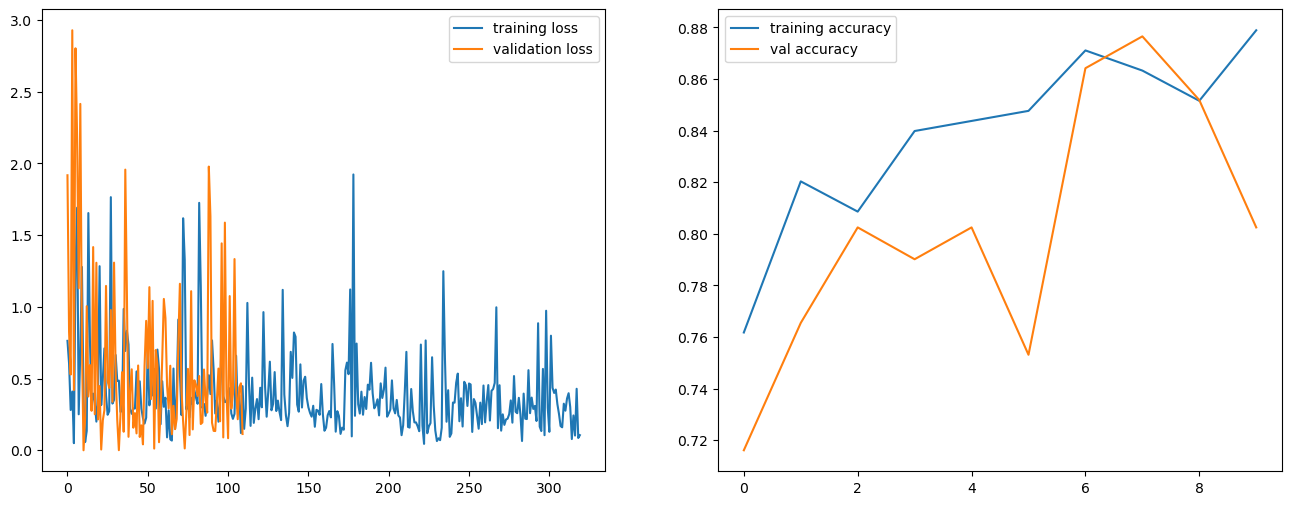

In [ ]:
# Plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(losses["train"], label="training loss")
ax1.plot(losses["val"], label="validation loss")
ax1.legend()

ax2.plot(hist["train"],label="training accuracy")
ax2.plot(hist["val"],label="val accuracy")
ax2.legend()

plt.show()

In [ ]:
subset_indices_test = torch.randperm(len(image_datasets['test']))[:int(0.3*len(image_datasets['test']))]
test_data_subset = torch.utils.data.Subset(image_datasets['test'], subset_indices_test)
test_dataloader = torch.utils.data.DataLoader(test_data_subset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()

    loss = running_loss / len(dataloader.dataset)
    accuracy = running_corrects / len(dataloader.dataset)

    return loss, accuracy

test_loss, test_accuracy = evaluate_model(model, test_dataloader)

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_accuracy))


Test Loss: 0.3985, Test Accuracy: 0.8375


In [ ]:
list_img_names = []

counter = 0
for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    for j in range(inputs.size(0)):
        # Obtener el nombre de la imagen
        image_index = i * test_dataloader.batch_size + j
        image_path = test_data_subset.dataset.samples[image_index][0]
        image_name = os.path.basename(image_path)
        print("Nombre de la imagen: {}".format(image_name))
        list_img_names.append(image_name)
        # Loading and showing the image
        image = inputs[j].permute(1, 2, 0).cpu().numpy()

        # Normalizing the image
        image = (image - image.min()) / (image.max() - image.min())

        """
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        """
        # Print the prediction and the correct label
        prediction = preds[j].item()
        correct_label = labels[j].item()
        print("Predicción: {}, Etiqueta correcta: {}".format(prediction, correct_label))

Nombre de la imagen: 10253_idx5_x1001_y1301_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1051_y1501_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1051_y401_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1051_y651_class0.png
Predicción: 0, Etiqueta correcta: 1
Nombre de la imagen: 10253_idx5_x1101_y1051_class0.png
Predicción: 0, Etiqueta correcta: 1
Nombre de la imagen: 10253_idx5_x1101_y1151_class0.png
Predicción: 0, Etiqueta correcta: 1
Nombre de la imagen: 10253_idx5_x1101_y401_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1101_y701_class0.png
Predicción: 1, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1101_y801_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1101_y851_class0.png
Predicción: 1, Etiqueta correcta: 1
Nombre de la imagen: 10253_idx5_x1101_y951_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre

In [ ]:
patient_ids = []
for name in list_img_names:
    id = name.split('_')[0]
    patient_ids.append(id)

In [ ]:
ids_unique = list(set(patient_ids))

In [ ]:
base_path = main_folder

In [ ]:

def get_cancer_dataframe(patient_id, cancer_id):
    path = os.path.join(base_path, patient_id, cancer_id)
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = [os.path.join(path, filename) for filename in dataframe.filename.values]
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df

In [ ]:
def visualise_breast_tissue_base(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape=(max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            target = example_df.target.values[n]
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                proba = patient_df[(patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    return grid, mask, broken_patches, mask_proba

In [ ]:
def visualise_breast_tissue(patient_id):
    grid, mask, broken_patches,_ = visualise_breast_tissue_base(patient_id)

    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("X-coord")
        ax[m].set_ylabel("Y-coord")
    ax[0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id)

    plt.show()

In [ ]:
def visualise_breast_tissue_binary(patient_id):
        
    fig, ax = plt.subplots(1, 1)

    example_df = get_patient_dataframe(patient_id)

    ax.scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20)
    ax.set_title("Patient " + patient_id)
    ax.set_xlabel("X coord")
    ax.set_ylabel("Y coord")
    ax.set_aspect('equal')  # Set aspect ratio to 'equal' to preserve original orientation
    ax.invert_yaxis()  # Reverse the y-axis direction

    plt.show()


In [ ]:
# Obtener 5 elementos aleatorios de la lista
random_patient_ids = random.sample(patient_ids, k=5)

In [ ]:
for id in random_patient_ids: #ids_unique:
    print("Patient's ID: ", id)
    visualise_breast_tissue(id)
    visualise_breast_tissue_binary(id)
    print("\n")